In [1]:
import DirectDmTargets as dddm

calculating effective efficancy for Xe detector done
calculating effective efficancy for Ar detector done
calculating effective efficancy for Ge detector done


In [2]:
import wimprates as wr

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numericalunits as nu

In [5]:
from tqdm import tqdm

In [6]:
from scipy.integrate import quad as scipy_int

# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

## HALO model ##



d:\google drive\phd-master\ubuntu-storage\windows-anaconda\wimprates\wimprates\halo.py:129: RuntimeWarning: divide by zero encountered in true_divide
  / (2 * v_earth_t * v))


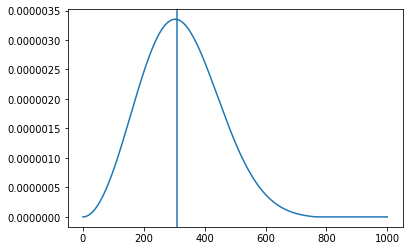

In [7]:
x = np.linspace(0,1000,200) * nu.km / nu.s
y2 = wr.observed_speed_dist(x, 0)
plt.plot(x/(nu.km / nu.s),y2)
plt.axvline(310)

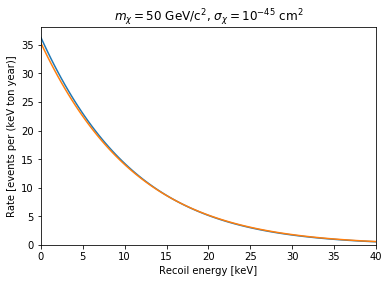

In [8]:
# NR's
energies = np.linspace(0.001, 40, 100)

# dr/dr
dr = wr.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45)

plt.plot(energies, dr)

plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title("$m_\chi = 50$ GeV/c${}^2$, $\sigma_\chi = 10^{-45}$ cm${}^2$")
plt.xlim(0, energies.max())
plt.ylim(0, None);

use_SHM = dddm.SHM()
dr_shm = wr.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45, halo_model = use_SHM)
plt.plot(energies, dr_shm, label = "Modified SHM")


## Detector smearing

In [9]:
import DirectDmTargets as dddm
from tqdm import tqdm
import matplotlib.pyplot as plt

In [10]:
# _bin_low, _bin_high, _nbin = 0.001, 40, 10
# for _bin in tqdm(dddm.get_bins(_bin_low, _bin_high, _nbin)):
#     x = _bin.mean()
#     y = dddm.N_r(_bin[0], _bin[1], 1, smearing = False)
#     plt.scatter(x,y, c = 'r')
# for _bin in tqdm(dddm.get_bins(_bin_low, _bin_high, _nbin)):
#     x = _bin.mean()
#     y = dddm.N_r(_bin[0], _bin[1], 1, smearing = True)
#     plt.scatter(x,y, c = 'b', label = 'smeared')
    
# plt.ylabel("N events [keV$^{-1}$]")
# plt.xlabel("Recoil energy [keV]")

In [11]:
# TO DO

# Inference #
Below we setup the inference

# Emcee #
<https://emcee.readthedocs.io/en/stable/tutorials/quickstart/>

In [12]:
import pandas as pd

In [13]:
import scipy

In [14]:
import emcee
emcee.__version__

'3.0.0'

## Distribution of the DM ##
First we need to make a DM-rate spectrum

In [15]:
benchmark = {'mw':50, 'sigma_nucleon':10e-45}
detectors = {
    'Xe':{'exp':  5, 'cut_eff': 0.8, 'nr_eff':0.5, 'E_thr':10, 'res': dddm.det_res_Xe},
    'Ar':{'exp':  3, 'cut_eff': 0.8, 'nr_eff':0.9, 'E_thr':10, 'res': dddm.det_res_Ar},
    'Ge':{'exp': 10, 'cut_eff': 0.8, 'nr_eff':0.8, 'E_thr':30, 'res': dddm.det_res_Ge}}
for name in detectors.keys():    
    detectors[name]['exp_eff'] = (detectors[name]['exp'] * 
                                  detectors[name]['cut_eff'] * 
                                  detectors[name]['nr_eff'])
    print(f"calculating effective efficency for {name} detector done")

calculating effective efficency for Xe detector done
calculating effective efficency for Ar detector done
calculating effective efficency for Ge detector done


In [16]:
use_SHM = dddm.SHM()
xe_events = dddm.GenSpectrum(50, 10e-45, use_SHM, detectors['Xe'])
xe_data = xe_events.get_data(poisson = True)
xe_data

,counts,bin_centers,bin_left,bin_right
0,4419,5.0,0.0,10.0
1,1688,15.0,10.0,20.0
2,596,25.0,20.0,30.0
3,209,35.0,30.0,40.0
4,58,45.0,40.0,50.0
5,25,55.0,50.0,60.0
6,7,65.0,60.0,70.0
7,0,75.0,70.0,80.0
8,0,85.0,80.0,90.0
9,0,95.0,90.0,100.0


In [17]:
dddm.GenSpectrum(50, 10e-50, use_SHM, detectors['Xe']).get_data(poisson = False)

,counts,bin_centers,bin_left,bin_right
0,4.499673e-02,5.0,0.0,10.0
1,1.725414e-02,15.0,10.0,20.0
2,6.155139e-03,25.0,20.0,30.0
3,2.037773e-03,35.0,30.0,40.0
4,6.183480e-04,45.0,40.0,50.0
5,1.675711e-04,55.0,50.0,60.0
6,3.849836e-05,65.0,60.0,70.0
7,6.650506e-06,75.0,70.0,80.0
8,5.831343e-07,85.0,80.0,90.0
9,1.524773e-09,95.0,90.0,100.0


In [18]:
dddm.log_likelihood_df(xe_data, xe_data)

-0.9037903176782212

  0%|                                                                                        | 0/30 [00:00<?, ?it/s]D:\Google Drive\PhD-master\ubuntu-storage\windows-anaconda\DD_DM_targets\DirectDmTargets\statistics.py:56: RuntimeWarning: divide by zero encountered in log
  return np.log(((Nr**Nb) /np.math.gamma(Nb+1)) * np.exp(-Nr))
100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.84it/s]


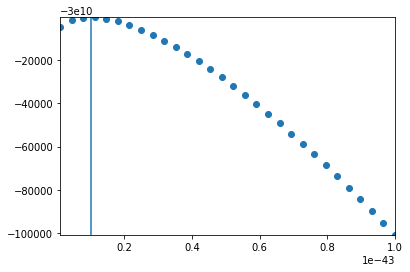

In [19]:
dddm.plt_ll_sigma()

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 113.51it/s]


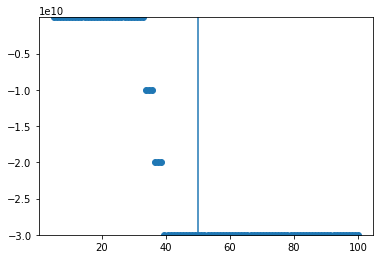

In [20]:
dddm.plt_ll_mass()

In [21]:
xe_data['counts']

0    4419
1    1688
2     596
3     209
4      58
5      25
6       7
7       0
8       0
9       0
Name: counts, dtype: int32

In [22]:
priors = {
    'log_mass':         {'range':[0.1,3],    'prior_type':'flat'},
    'log_cross_secion': {'range':[-10, -6],    'prior_type':'flat'}, 
    'density':          {'range':[0.001, 0.9], 'prior_type':'gauss', 'mean':0.4, 'std':0.1} ,
    'v_0':              {'range':[80, 380],    'prior_type':'gauss', 'mean':230, 'std':30}, 
    'v_esc':            {'range':[379, 709],   'prior_type':'gauss', 'mean':544, 'std':33}, 
    'k':                {'range':[0.5, 3.5],   'prior_type':'flat'} 
}

for key in priors.keys():
    param = priors[key]
    if param['prior_type'] == 'flat':
        param['param'] = param['range']
        param['dist'] = lambda x: flat_prior(x)
    elif param['prior_type'] == 'gauss':
        param['param'] = param['mean'], param['std']
        param['dist'] = lambda x: gaus_prior(x)
    

In [23]:
pos = 50 + np.random.randn(32, 1)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                dddm.log_probability, args=(xe_data['bin_centers'],
                                                            xe_data['counts'],
                                                           'log_mass'))
sampler.run_mcmc(pos, 50, progress=True);

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s]


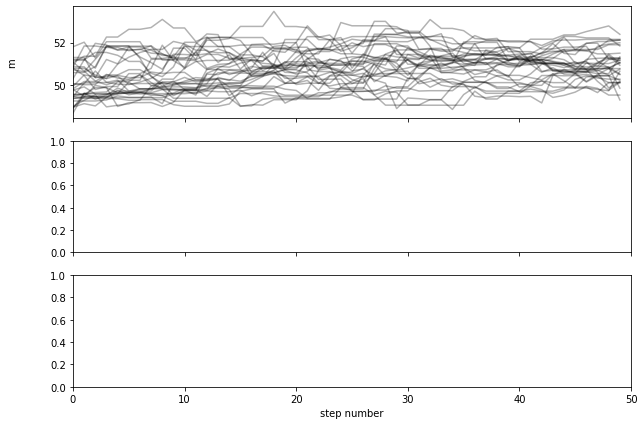

In [24]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [25]:
a,b = np.array([0, 1]), np.array([2, 3])

In [26]:
def ADD(a,b):
    return a+b

In [27]:
dddm.log_prior(1e-45, 'log_mass')

-inf

In [ ]:
priors = {'log_cross_secion': {'range': [-46, -42], 'prior_type': 'flat'}}
for key in priors.keys():
    param = priors[key]
    if param['prior_type'] == 'flat':
        param['param'] = param['range']
        param['dist'] = lambda x: flat_prior(x)
    elif param['prior_type'] == 'gauss':
        param['param'] = param['mean'], param['std']
        param['dist'] = lambda x: gaus_prior(x)

In [ ]:
def log_flat(x, x_name):
    a, b = priors[x_name]['param']
    try:
        if a < x < b:
            return 0
        else:
            return -np.inf
    except ValueError:
        result = np.zeros(len(x))
        mask = (x > a) & (x < b)
        result[~mask] = -np.inf
        return result

In [ ]:
def log_prior(x, x_name):
    if priors[x_name]['prior_type'] == 'flat':
        if 'log' in x_name:
            return log_flat(np.log10(x), x_name)
        else:
            return log_flat(x, x_name)
    elif priors[x_name]['prior_type'] == 'gauss':
        return log_gauss(x, x_name)
    else:
        raise TypeError(f"unknown prior type '{priors[x_name]['prior_type']}', choose either gauss or flat")

In [34]:
nwalkers = 100
pos = np.hstack(
    [50 + np.random.randn(nwalkers, 1) ,
    1e-45 + 1e-45 * np.random.randn(nwalkers, 1)])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                dddm.log_probability, args=(xe_data['bin_centers'],
                                                            xe_data['counts'],
                                                           ['log_mass', 
                                                            'log_cross_secion']))
sampler.run_mcmc(pos, 50, progress=True);

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.16it/s]


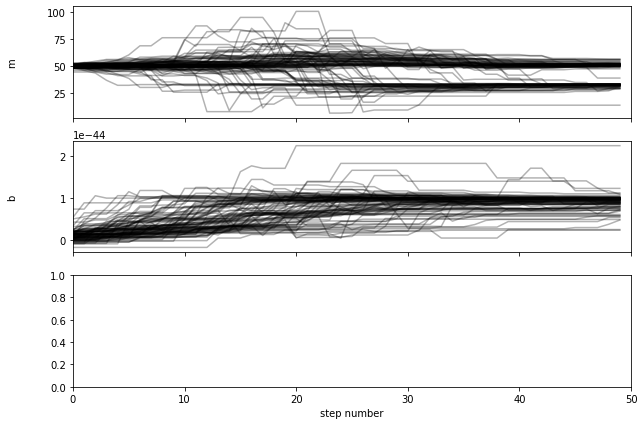

In [35]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [36]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.62752706 5.85078627]

In [37]:
flat_samples = sampler.get_chain(discard=10, thin=15, flat=True)
print(flat_samples.shape)

(200, 2)


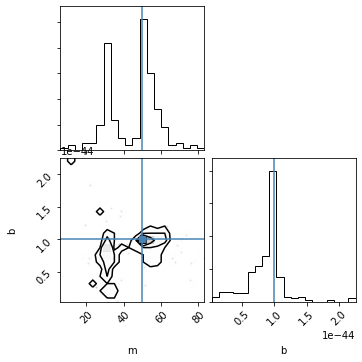

In [38]:
import corner
fig = corner.corner(flat_samples, labels=labels, truths=[50, 10e-45]);